<a href="https://colab.research.google.com/github/alierenc/di725-transformers-and-attention-based-deep-networks/blob/main/Assignment1/3.%20Fine-tuning%20GPT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

# Mount Google Drive to access dataset and save models
drive.mount('/content/drive')

# Load the dataset
train_data_path = "/content/drive/MyDrive/DI725 - Transformers and Attention-based Deep Networks/Assignment 1/train_data.csv"
val_data_path = "/content/drive/MyDrive/DI725 - Transformers and Attention-based Deep Networks/Assignment 1/validation_data.csv"
test_data_path = "/content/drive/MyDrive/DI725 - Transformers and Attention-based Deep Networks/Assignment 1/test_data.csv"

!pip install wandb

import wandb
wandb.login()

!pip install transformers datasets

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: aeren to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from transformers import GPT2Tokenizer

# Load dataset from CSV
def load_data(csv_file):
    df = pd.read_csv(csv_file)
    texts = df['conversation'].tolist()
    labels = df['customer_sentiment'].tolist()
    return texts, labels

# Load train, validation, and test data
train_texts, train_labels = load_data(train_data_path)
val_texts, val_labels = load_data(val_data_path)
test_texts, test_labels = load_data(test_data_path)

# Label encoding
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)
test_labels = label_encoder.transform(test_labels)

# Load Hugging Face GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Tokenization function
def encode_data(texts, labels, tokenizer, max_length=256):
    encodings = tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )
    labels = torch.tensor(labels)
    return TensorDataset(encodings['input_ids'], encodings['attention_mask'], labels)

# Create datasets
train_dataset = encode_data(train_texts, train_labels, tokenizer)
val_dataset = encode_data(val_texts, val_labels, tokenizer)
test_dataset = encode_data(test_texts, test_labels, tokenizer)

# DataLoaders
batch_size = 12
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import os
import time
import torch
from contextlib import nullcontext
from sklearn.metrics import classification_report
from torch.cuda.amp import GradScaler
from transformers import GPT2ForSequenceClassification
from torch.optim import AdamW

# Initialize wandb
wandb.init(project="sentiment_analysis_project", name="gpt2_classification_run")

# Training config
out_dir = 'out'
os.makedirs(out_dir, exist_ok=True)

eval_interval = 50
log_interval = 50
max_iters = 1000
always_save_checkpoint = True

gradient_accumulation_steps = 2
# batch_size = 12

learning_rate = 6e-4
weight_decay = 1e-1
beta1 = 0.9
beta2 = 0.95
grad_clip = 1.0

device = 'cuda' if torch.cuda.is_available() else 'cpu'
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
device_type = 'cuda' if 'cuda' in device else 'cpu'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

# Load pretrained GPT-2 model for classification
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=3)
model.config.pad_token_id = model.config.eos_token_id
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate, betas=(beta1, beta2), weight_decay=weight_decay)
scaler = GradScaler()

# Dataloaders assumed to be: train_loader, val_loader (already created)
train_iter = iter(train_loader)
val_iter = iter(val_loader)

def get_batch(split):
    global train_iter, val_iter
    try:
        if split == 'train':
            x, attn_mask, y = next(train_iter)
        else:
            x, attn_mask, y = next(val_iter)
    except StopIteration:
        if split == 'train':
            train_iter = iter(train_loader)
            x, attn_mask, y = next(train_iter)
        else:
            val_iter = iter(val_loader)
            x, attn_mask, y = next(val_iter)
    return x.to(device), attn_mask.to(device), y.to(device)

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split, loader in [('train', train_loader), ('val', val_loader)]:
        losses, correct, total = [], 0, 0
        for x, attn_mask, y in loader:
            x, attn_mask, y = x.to(device), attn_mask.to(device), y.to(device)
            outputs = model(input_ids=x, attention_mask=attn_mask, labels=y)
            losses.append(outputs.loss.item())
            preds = outputs.logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
        out[split] = sum(losses) / len(losses)
        out[f"{split}_acc"] = correct / total
    model.train()
    return out

# Early stopping setup
val_loss_history = []
early_stop_patience = 10

# Training loop
iter_num = 0
best_val_loss = float('inf')
t0 = time.time()

while iter_num <= max_iters:
    lr = learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # Evaluate and log
    if iter_num % eval_interval == 0:
        losses = estimate_loss()
        val_loss = losses['val']
        print(f"step {iter_num}: train loss {losses['train']:.4f}, train acc {losses['train_acc']:.4f}, val loss {val_loss:.4f}, val acc {losses['val_acc']:.4f}")
        wandb.log({
            "train/loss": losses['train'],
            "train/accuracy": losses['train_acc'],
            "val/loss": val_loss,
            "val/accuracy": losses['val_acc'],
            "step": iter_num
        })

        val_loss_history.append(val_loss)
        if len(val_loss_history) > early_stop_patience:
            val_loss_history.pop(0)
            if all(val_loss >= prev for prev in val_loss_history):
                print(f"Early stopping: No improvement in val loss for {early_stop_patience} evaluations.")
                break

        if val_loss < best_val_loss or always_save_checkpoint:
            best_val_loss = val_loss
            checkpoint = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'iter_num': iter_num,
                'best_val_loss': best_val_loss,
            }
            torch.save(checkpoint, os.path.join(out_dir, 'ckpt.pt'))

    # Training step with accumulation
    for micro_step in range(gradient_accumulation_steps):
        x, attn_mask, y = get_batch('train')
        with ctx:
            outputs = model(input_ids=x, attention_mask=attn_mask, labels=y)
            loss = outputs.loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

    if grad_clip != 0.0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    scaler.step(optimizer)
    scaler.update()
    optimizer.zero_grad(set_to_none=True)

    if iter_num % log_interval == 0:
        print(f"iter {iter_num}: loss {loss.item() * gradient_accumulation_steps:.4f}, time {(time.time()-t0)*1000:.2f}ms")
        wandb.log({"train/batch_loss": loss.item() * gradient_accumulation_steps, "step": iter_num})
        t0 = time.time()

    iter_num += 1


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-3-93e702263e5c>:44: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


step 0: train loss 12.4876, train acc 0.0399, val loss 13.0434, val acc 0.0309
iter 0: loss 13.4948, time 5540.35ms
step 50: train loss 0.5557, train acc 0.7951, val loss 0.8141, val acc 0.7268
iter 50: loss 0.6946, time 10476.13ms
step 100: train loss 0.2135, train acc 0.9278, val loss 0.6154, val acc 0.7938
iter 100: loss 0.2293, time 10766.31ms
step 150: train loss 0.1046, train acc 0.9716, val loss 1.0515, val acc 0.8196
iter 150: loss 0.9545, time 10432.26ms
step 200: train loss 0.0844, train acc 0.9716, val loss 1.1436, val acc 0.7887
iter 200: loss 0.3830, time 11624.52ms
step 250: train loss 0.0048, train acc 0.9987, val loss 1.3592, val acc 0.7938
iter 250: loss 0.0006, time 10757.89ms
step 300: train loss 0.0333, train acc 0.9936, val loss 1.6475, val acc 0.8144
iter 300: loss 0.0000, time 10512.19ms
step 350: train loss 0.0241, train acc 0.9948, val loss 1.7146, val acc 0.8351
iter 350: loss 0.5052, time 10510.35ms
step 400: train loss 0.0153, train acc 0.9948, val loss 1.51


Overall Accuracy: 66.67%

Class-wise Accuracy:
  Class 0 (negative): 90.00%
  Class 1 (neutral): 90.00%
  Class 2 (positive): 20.00%

Classification Report:
              precision    recall  f1-score   support

    negative       0.90      0.90      0.90        10
     neutral       0.50      0.90      0.64        10
    positive       1.00      0.20      0.33        10

    accuracy                           0.67        30
   macro avg       0.80      0.67      0.63        30
weighted avg       0.80      0.67      0.63        30


Confusion Matrix (as table):
          negative  neutral   positive  
negative  9         1         0         
neutral   1         9         0         
positive  0         8         2         


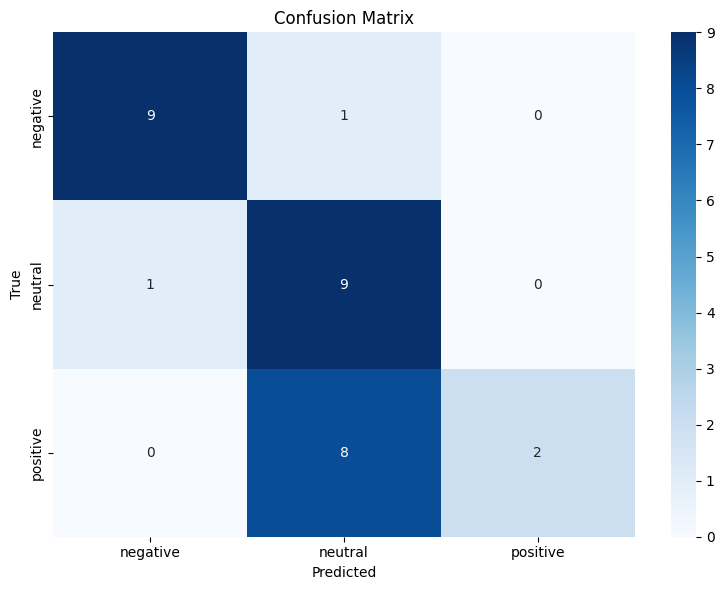

In [ ]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

# Evaluate the model on the test set
model.eval()

predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_labels = logits.argmax(dim=-1).cpu().numpy()

        predictions.extend(predicted_labels)
        true_labels.extend(labels.cpu().numpy())

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Overall accuracy
overall_accuracy = accuracy_score(true_labels, predictions)
print(f"\nOverall Accuracy: {overall_accuracy * 100:.2f}%")

# Class-wise accuracy
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
print("\nClass-wise Accuracy:")
for i, acc in enumerate(class_accuracy):
    print(f"  Class {i} ({label_encoder.classes_[i]}): {acc * 100:.2f}%")

# Classification report
print("\nClassification Report:")
report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)
print(report)

# Print confusion matrix
ordered_labels = ['negative', 'neutral', 'positive']
ordered_indices = [list(label_encoder.classes_).index(label) for label in ordered_labels]

reordered_conf_matrix = conf_matrix[np.ix_(ordered_indices, ordered_indices)]

# Print confusion matrix
print("\nConfusion Matrix (as table):")
print("{:<10}".format(""), end="")
for label in ordered_labels:
    print("{:<10}".format(label), end="")
print()

for i, row_idx in enumerate(ordered_indices):
    row_label = ordered_labels[i]
    print("{:<10}".format(row_label), end="")
    for col_idx in ordered_indices:
        print("{:<10}".format(conf_matrix[row_idx][col_idx]), end="")
    print()


# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
